# First Example

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

torch.manual_seed(42)

# read data and apply one-hot encoding
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv", header=None)
X = data.iloc[:, 0:4]
y = data.iloc[:, 4:]
print(y.value_counts())
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
y = ohe.transform(y)

# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=123)

4              
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


In [2]:
data

0    1    2    3               4
0    5.1  3.5  1.4  0.2     Iris-setosa
1    4.9  3.0  1.4  0.2     Iris-setosa
2    4.7  3.2  1.3  0.2     Iris-setosa
3    4.6  3.1  1.5  0.2     Iris-setosa
4    5.0  3.6  1.4  0.2     Iris-setosa
..   ...  ...  ...  ...             ...
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

[150 rows x 5 columns]

In [9]:
class Multiclass(nn.Module):   # DEFINIR A ESTRUTURA DA REDE NEURONAL
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8) # O 1º NUMERO É DEFINIDO PELO NUMERO DE COLUNAS QUE TEMOS
        self.act = nn.ReLU()          # FUNÇÃO DE ATIVAÇÃO
        self.output = nn.Linear(8, 3) # O ULTIMO NUMERO (3) DEFINE O NUMERO DE OBJETIVOS. NESTE CASO QUEREMOS 3 PORQUE TEMOS 3 CATEGORIAS DE 'IRIS' 

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# loss metric and optimizer
model = Multiclass()


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
n_epochs = 200
batch_size = 5
batches_per_epoch = len(X_train) // batch_size
 
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:  # CRIA AS BARRAS DE PROCESSO
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")


Epoch 0: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 332.91batch/s, acc=0.2, loss=1.93]


Epoch 0 validation: Cross-entropy=1.46, Accuracy=40.0%


Epoch 1: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 227.24batch/s, acc=0.2, loss=1.57]


Epoch 1 validation: Cross-entropy=1.25, Accuracy=40.0%


Epoch 2: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 148.15batch/s, acc=0.2, loss=1.34]


Epoch 2 validation: Cross-entropy=1.13, Accuracy=40.0%


Epoch 3: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 86.75batch/s, acc=0.4, loss=1.19]


Epoch 3 validation: Cross-entropy=1.07, Accuracy=62.2%


Epoch 4: 100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 69.65batch/s, acc=0.6, loss=1.1]


Epoch 4 validation: Cross-entropy=1.05, Accuracy=77.8%


Epoch 5: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 154.17batch/s, acc=0.4, loss=1.05]


Epoch 5 validation: Cross-entropy=1.05, Accuracy=42.2%


Epoch 6: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 268.31batch/s, acc=0.4, loss=1.03]


Epoch 6 validation: Cross-entropy=1.05, Accuracy=37.8%


Epoch 7: 100%|██████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 231.35batch/s, acc=0.6, loss=1]


Epoch 7 validation: Cross-entropy=1.04, Accuracy=31.1%


Epoch 8: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 262.72batch/s, acc=0.4, loss=0.98]


Epoch 8 validation: Cross-entropy=1.02, Accuracy=20.0%


Epoch 9: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 135.20batch/s, acc=0.4, loss=0.956]


Epoch 9 validation: Cross-entropy=0.99, Accuracy=24.4%


Epoch 10: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 76.32batch/s, acc=0.4, loss=0.932]


Epoch 10 validation: Cross-entropy=0.96, Accuracy=22.2%


Epoch 11: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 120.28batch/s, acc=0.4, loss=0.911]


Epoch 11 validation: Cross-entropy=0.94, Accuracy=28.9%


Epoch 12: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 152.00batch/s, acc=0.6, loss=0.892]


Epoch 12 validation: Cross-entropy=0.91, Accuracy=62.2%


Epoch 13: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 163.85batch/s, acc=0.6, loss=0.875]


Epoch 13 validation: Cross-entropy=0.88, Accuracy=68.9%


Epoch 14: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 204.04batch/s, acc=0.6, loss=0.859]


Epoch 14 validation: Cross-entropy=0.85, Accuracy=73.3%


Epoch 15: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 179.50batch/s, acc=0.8, loss=0.843]


Epoch 15 validation: Cross-entropy=0.83, Accuracy=75.6%


Epoch 16: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 167.39batch/s, acc=0.8, loss=0.828]


Epoch 16 validation: Cross-entropy=0.80, Accuracy=75.6%


Epoch 17: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 171.11batch/s, acc=0.8, loss=0.813]


Epoch 17 validation: Cross-entropy=0.78, Accuracy=75.6%


Epoch 18: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 167.16batch/s, acc=0.8, loss=0.798]


Epoch 18 validation: Cross-entropy=0.75, Accuracy=75.6%


Epoch 19: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 143.63batch/s, acc=0.8, loss=0.783]


Epoch 19 validation: Cross-entropy=0.73, Accuracy=80.0%


Epoch 20: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.54batch/s, acc=0.8, loss=0.768]


Epoch 20 validation: Cross-entropy=0.71, Accuracy=80.0%


Epoch 21: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 142.34batch/s, acc=0.8, loss=0.754]


Epoch 21 validation: Cross-entropy=0.69, Accuracy=80.0%


Epoch 22: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 172.34batch/s, acc=0.8, loss=0.741]


Epoch 22 validation: Cross-entropy=0.67, Accuracy=80.0%


Epoch 23: 100%|█████████████████████████████████████████████████████| 21/21 [00:00<00:00, 159.54batch/s, acc=0.8, loss=0.727]


Epoch 23 validation: Cross-entropy=0.65, Accuracy=82.2%


Epoch 24: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 128.55batch/s, acc=1, loss=0.715]


Epoch 24 validation: Cross-entropy=0.63, Accuracy=82.2%


Epoch 25: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 133.91batch/s, acc=1, loss=0.703]


Epoch 25 validation: Cross-entropy=0.61, Accuracy=86.7%


Epoch 26: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 71.71batch/s, acc=1, loss=0.691]


Epoch 26 validation: Cross-entropy=0.60, Accuracy=86.7%


Epoch 27: 100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 90.30batch/s, acc=1, loss=0.68]


Epoch 27 validation: Cross-entropy=0.58, Accuracy=86.7%


Epoch 28: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.35batch/s, acc=1, loss=0.67]


Epoch 28 validation: Cross-entropy=0.57, Accuracy=86.7%


Epoch 29: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 103.04batch/s, acc=1, loss=0.659]


Epoch 29 validation: Cross-entropy=0.55, Accuracy=88.9%


Epoch 30: 100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 97.56batch/s, acc=1, loss=0.65]


Epoch 30 validation: Cross-entropy=0.54, Accuracy=88.9%


Epoch 31: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 160.78batch/s, acc=1, loss=0.64]


Epoch 31 validation: Cross-entropy=0.53, Accuracy=88.9%


Epoch 32: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 233.46batch/s, acc=1, loss=0.631]


Epoch 32 validation: Cross-entropy=0.52, Accuracy=88.9%


Epoch 33: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 175.44batch/s, acc=1, loss=0.622]


Epoch 33 validation: Cross-entropy=0.51, Accuracy=88.9%


Epoch 34: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 58.98batch/s, acc=1, loss=0.614]


Epoch 34 validation: Cross-entropy=0.50, Accuracy=91.1%


Epoch 35: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 151.65batch/s, acc=1, loss=0.606]


Epoch 35 validation: Cross-entropy=0.49, Accuracy=91.1%


Epoch 36: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 187.31batch/s, acc=1, loss=0.598]


Epoch 36 validation: Cross-entropy=0.48, Accuracy=91.1%


Epoch 37: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 177.69batch/s, acc=1, loss=0.59]


Epoch 37 validation: Cross-entropy=0.47, Accuracy=91.1%


Epoch 38: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 83.77batch/s, acc=1, loss=0.583]


Epoch 38 validation: Cross-entropy=0.47, Accuracy=91.1%


Epoch 39: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 98.33batch/s, acc=1, loss=0.576]


Epoch 39 validation: Cross-entropy=0.46, Accuracy=91.1%


Epoch 40: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 171.07batch/s, acc=1, loss=0.569]


Epoch 40 validation: Cross-entropy=0.45, Accuracy=93.3%


Epoch 41: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 194.29batch/s, acc=1, loss=0.562]


Epoch 41 validation: Cross-entropy=0.45, Accuracy=93.3%


Epoch 42: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 235.94batch/s, acc=1, loss=0.556]


Epoch 42 validation: Cross-entropy=0.44, Accuracy=93.3%


Epoch 43: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 266.91batch/s, acc=1, loss=0.549]


Epoch 43 validation: Cross-entropy=0.43, Accuracy=93.3%


Epoch 44: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 237.47batch/s, acc=1, loss=0.543]


Epoch 44 validation: Cross-entropy=0.43, Accuracy=93.3%


Epoch 45: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 245.61batch/s, acc=1, loss=0.536]


Epoch 45 validation: Cross-entropy=0.42, Accuracy=93.3%


Epoch 46: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 200.90batch/s, acc=1, loss=0.53]


Epoch 46 validation: Cross-entropy=0.42, Accuracy=93.3%


Epoch 47: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 259.98batch/s, acc=1, loss=0.524]


Epoch 47 validation: Cross-entropy=0.41, Accuracy=93.3%


Epoch 48: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 288.44batch/s, acc=1, loss=0.518]


Epoch 48 validation: Cross-entropy=0.41, Accuracy=93.3%


Epoch 49: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 201.13batch/s, acc=1, loss=0.512]


Epoch 49 validation: Cross-entropy=0.40, Accuracy=93.3%


Epoch 50: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 150.09batch/s, acc=1, loss=0.506]


Epoch 50 validation: Cross-entropy=0.40, Accuracy=93.3%


Epoch 51: 100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 167.18batch/s, acc=1, loss=0.5]


Epoch 51 validation: Cross-entropy=0.39, Accuracy=93.3%


Epoch 52: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 90.30batch/s, acc=1, loss=0.495]


Epoch 52 validation: Cross-entropy=0.39, Accuracy=93.3%


Epoch 53: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 95.88batch/s, acc=1, loss=0.489]


Epoch 53 validation: Cross-entropy=0.38, Accuracy=93.3%


Epoch 54: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 66.33batch/s, acc=1, loss=0.484]


Epoch 54 validation: Cross-entropy=0.38, Accuracy=93.3%


Epoch 55: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 95.63batch/s, acc=1, loss=0.478]


Epoch 55 validation: Cross-entropy=0.37, Accuracy=93.3%


Epoch 56: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 127.27batch/s, acc=1, loss=0.472]


Epoch 56 validation: Cross-entropy=0.37, Accuracy=93.3%


Epoch 57: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 264.00batch/s, acc=1, loss=0.467]


Epoch 57 validation: Cross-entropy=0.36, Accuracy=93.3%


Epoch 58: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 159.35batch/s, acc=1, loss=0.461]


Epoch 58 validation: Cross-entropy=0.36, Accuracy=93.3%


Epoch 59: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 168.37batch/s, acc=1, loss=0.456]


Epoch 59 validation: Cross-entropy=0.35, Accuracy=93.3%


Epoch 60: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 126.02batch/s, acc=1, loss=0.45]


Epoch 60 validation: Cross-entropy=0.35, Accuracy=93.3%


Epoch 61: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 144.93batch/s, acc=1, loss=0.445]


Epoch 61 validation: Cross-entropy=0.35, Accuracy=93.3%


Epoch 62: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.26batch/s, acc=1, loss=0.44]


Epoch 62 validation: Cross-entropy=0.34, Accuracy=93.3%


Epoch 63: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 169.65batch/s, acc=1, loss=0.435]


Epoch 63 validation: Cross-entropy=0.34, Accuracy=93.3%


Epoch 64: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 102.21batch/s, acc=1, loss=0.43]


Epoch 64 validation: Cross-entropy=0.33, Accuracy=93.3%


Epoch 65: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 198.17batch/s, acc=1, loss=0.425]


Epoch 65 validation: Cross-entropy=0.33, Accuracy=93.3%


Epoch 66: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 202.28batch/s, acc=1, loss=0.42]


Epoch 66 validation: Cross-entropy=0.33, Accuracy=93.3%


Epoch 67: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 134.07batch/s, acc=1, loss=0.415]


Epoch 67 validation: Cross-entropy=0.32, Accuracy=93.3%


Epoch 68: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 134.19batch/s, acc=1, loss=0.41]


Epoch 68 validation: Cross-entropy=0.32, Accuracy=93.3%


Epoch 69: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 119.87batch/s, acc=1, loss=0.405]


Epoch 69 validation: Cross-entropy=0.31, Accuracy=93.3%


Epoch 70: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 175.64batch/s, acc=1, loss=0.401]


Epoch 70 validation: Cross-entropy=0.31, Accuracy=93.3%


Epoch 71: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 95.24batch/s, acc=1, loss=0.396]


Epoch 71 validation: Cross-entropy=0.31, Accuracy=93.3%


Epoch 72: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 207.51batch/s, acc=1, loss=0.392]


Epoch 72 validation: Cross-entropy=0.30, Accuracy=93.3%


Epoch 73: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 177.91batch/s, acc=1, loss=0.387]


Epoch 73 validation: Cross-entropy=0.30, Accuracy=93.3%


Epoch 74: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 182.63batch/s, acc=1, loss=0.383]


Epoch 74 validation: Cross-entropy=0.30, Accuracy=93.3%


Epoch 75: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 181.43batch/s, acc=1, loss=0.378]


Epoch 75 validation: Cross-entropy=0.29, Accuracy=93.3%


Epoch 76: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 183.99batch/s, acc=1, loss=0.374]


Epoch 76 validation: Cross-entropy=0.29, Accuracy=93.3%


Epoch 77: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 181.90batch/s, acc=1, loss=0.37]


Epoch 77 validation: Cross-entropy=0.29, Accuracy=93.3%


Epoch 78: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 206.72batch/s, acc=1, loss=0.366]


Epoch 78 validation: Cross-entropy=0.28, Accuracy=93.3%


Epoch 79: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 191.43batch/s, acc=1, loss=0.362]


Epoch 79 validation: Cross-entropy=0.28, Accuracy=93.3%


Epoch 80: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 130.61batch/s, acc=1, loss=0.358]


Epoch 80 validation: Cross-entropy=0.28, Accuracy=93.3%


Epoch 81: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 159.17batch/s, acc=1, loss=0.354]


Epoch 81 validation: Cross-entropy=0.27, Accuracy=95.6%


Epoch 82: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 211.65batch/s, acc=1, loss=0.35]


Epoch 82 validation: Cross-entropy=0.27, Accuracy=95.6%


Epoch 83: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 254.74batch/s, acc=1, loss=0.346]


Epoch 83 validation: Cross-entropy=0.27, Accuracy=95.6%


Epoch 84: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 248.09batch/s, acc=1, loss=0.342]


Epoch 84 validation: Cross-entropy=0.26, Accuracy=95.6%


Epoch 85: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 134.25batch/s, acc=1, loss=0.339]


Epoch 85 validation: Cross-entropy=0.26, Accuracy=95.6%


Epoch 86: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 187.94batch/s, acc=1, loss=0.335]


Epoch 86 validation: Cross-entropy=0.26, Accuracy=95.6%


Epoch 87: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 153.15batch/s, acc=1, loss=0.332]


Epoch 87 validation: Cross-entropy=0.25, Accuracy=95.6%


Epoch 88: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 243.99batch/s, acc=1, loss=0.328]


Epoch 88 validation: Cross-entropy=0.25, Accuracy=95.6%


Epoch 89: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 231.16batch/s, acc=1, loss=0.325]


Epoch 89 validation: Cross-entropy=0.25, Accuracy=95.6%


Epoch 90: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 268.43batch/s, acc=1, loss=0.322]


Epoch 90 validation: Cross-entropy=0.25, Accuracy=95.6%


Epoch 91: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 277.16batch/s, acc=1, loss=0.318]


Epoch 91 validation: Cross-entropy=0.24, Accuracy=95.6%


Epoch 92: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 304.54batch/s, acc=1, loss=0.315]


Epoch 92 validation: Cross-entropy=0.24, Accuracy=95.6%


Epoch 93: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 184.94batch/s, acc=1, loss=0.312]


Epoch 93 validation: Cross-entropy=0.24, Accuracy=95.6%


Epoch 94: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 289.59batch/s, acc=1, loss=0.309]


Epoch 94 validation: Cross-entropy=0.23, Accuracy=95.6%


Epoch 95: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 173.19batch/s, acc=1, loss=0.306]


Epoch 95 validation: Cross-entropy=0.23, Accuracy=95.6%


Epoch 96: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 210.53batch/s, acc=1, loss=0.303]


Epoch 96 validation: Cross-entropy=0.23, Accuracy=95.6%


Epoch 97: 100%|█████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 144.67batch/s, acc=1, loss=0.3]


Epoch 97 validation: Cross-entropy=0.23, Accuracy=95.6%


Epoch 98: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 139.85batch/s, acc=1, loss=0.297]


Epoch 98 validation: Cross-entropy=0.22, Accuracy=95.6%


Epoch 99: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 107.99batch/s, acc=1, loss=0.295]


Epoch 99 validation: Cross-entropy=0.22, Accuracy=95.6%


Epoch 100: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.03batch/s, acc=1, loss=0.292]


Epoch 100 validation: Cross-entropy=0.22, Accuracy=95.6%


Epoch 101: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 135.74batch/s, acc=1, loss=0.289]


Epoch 101 validation: Cross-entropy=0.22, Accuracy=95.6%


Epoch 102: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 179.16batch/s, acc=1, loss=0.287]


Epoch 102 validation: Cross-entropy=0.22, Accuracy=95.6%


Epoch 103: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 213.46batch/s, acc=1, loss=0.284]


Epoch 103 validation: Cross-entropy=0.21, Accuracy=95.6%


Epoch 104: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 182.82batch/s, acc=1, loss=0.281]


Epoch 104 validation: Cross-entropy=0.21, Accuracy=95.6%


Epoch 105: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 198.08batch/s, acc=1, loss=0.279]


Epoch 105 validation: Cross-entropy=0.21, Accuracy=95.6%


Epoch 106: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.18batch/s, acc=1, loss=0.276]


Epoch 106 validation: Cross-entropy=0.21, Accuracy=95.6%


Epoch 107: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 127.99batch/s, acc=1, loss=0.274]


Epoch 107 validation: Cross-entropy=0.21, Accuracy=95.6%


Epoch 108: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 197.00batch/s, acc=1, loss=0.271]


Epoch 108 validation: Cross-entropy=0.20, Accuracy=95.6%


Epoch 109: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 168.38batch/s, acc=1, loss=0.269]


Epoch 109 validation: Cross-entropy=0.20, Accuracy=95.6%


Epoch 110: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 243.25batch/s, acc=1, loss=0.267]


Epoch 110 validation: Cross-entropy=0.20, Accuracy=95.6%


Epoch 111: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 177.26batch/s, acc=1, loss=0.265]


Epoch 111 validation: Cross-entropy=0.20, Accuracy=95.6%


Epoch 112: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 126.69batch/s, acc=1, loss=0.262]


Epoch 112 validation: Cross-entropy=0.20, Accuracy=95.6%


Epoch 113: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 244.53batch/s, acc=1, loss=0.26]


Epoch 113 validation: Cross-entropy=0.19, Accuracy=95.6%


Epoch 114: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 242.51batch/s, acc=1, loss=0.258]


Epoch 114 validation: Cross-entropy=0.19, Accuracy=95.6%


Epoch 115: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 258.02batch/s, acc=1, loss=0.256]


Epoch 115 validation: Cross-entropy=0.19, Accuracy=95.6%


Epoch 116: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 296.98batch/s, acc=1, loss=0.254]


Epoch 116 validation: Cross-entropy=0.19, Accuracy=95.6%


Epoch 117: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 246.39batch/s, acc=1, loss=0.252]


Epoch 117 validation: Cross-entropy=0.19, Accuracy=95.6%


Epoch 118: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 230.87batch/s, acc=1, loss=0.25]


Epoch 118 validation: Cross-entropy=0.19, Accuracy=93.3%


Epoch 119: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 264.39batch/s, acc=1, loss=0.248]


Epoch 119 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 120: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 250.73batch/s, acc=1, loss=0.246]


Epoch 120 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 121: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 247.63batch/s, acc=1, loss=0.245]


Epoch 121 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 122: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 361.55batch/s, acc=1, loss=0.243]


Epoch 122 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 123: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 356.93batch/s, acc=1, loss=0.241]


Epoch 123 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 124: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 333.62batch/s, acc=1, loss=0.239]


Epoch 124 validation: Cross-entropy=0.18, Accuracy=93.3%


Epoch 125: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 323.87batch/s, acc=1, loss=0.238]


Epoch 125 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 126: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 359.28batch/s, acc=1, loss=0.236]


Epoch 126 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 127: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 362.85batch/s, acc=1, loss=0.234]


Epoch 127 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 128: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 378.79batch/s, acc=1, loss=0.233]


Epoch 128 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 129: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 336.97batch/s, acc=1, loss=0.231]


Epoch 129 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 130: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 389.27batch/s, acc=1, loss=0.23]


Epoch 130 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 131: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 379.76batch/s, acc=1, loss=0.228]


Epoch 131 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 132: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 382.52batch/s, acc=1, loss=0.226]


Epoch 132 validation: Cross-entropy=0.17, Accuracy=93.3%


Epoch 133: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 344.86batch/s, acc=1, loss=0.225]


Epoch 133 validation: Cross-entropy=0.16, Accuracy=93.3%


Epoch 134: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 338.60batch/s, acc=1, loss=0.224]


Epoch 134 validation: Cross-entropy=0.16, Accuracy=93.3%


Epoch 135: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 327.66batch/s, acc=1, loss=0.222]


Epoch 135 validation: Cross-entropy=0.16, Accuracy=93.3%


Epoch 136: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 323.93batch/s, acc=1, loss=0.221]


Epoch 136 validation: Cross-entropy=0.16, Accuracy=93.3%


Epoch 137: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 323.42batch/s, acc=1, loss=0.219]


Epoch 137 validation: Cross-entropy=0.16, Accuracy=93.3%


Epoch 138: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 299.98batch/s, acc=1, loss=0.218]


Epoch 138 validation: Cross-entropy=0.16, Accuracy=95.6%


Epoch 139: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 268.47batch/s, acc=1, loss=0.217]


Epoch 139 validation: Cross-entropy=0.16, Accuracy=95.6%


Epoch 140: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 370.98batch/s, acc=1, loss=0.215]


Epoch 140 validation: Cross-entropy=0.16, Accuracy=95.6%


Epoch 141: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 374.10batch/s, acc=1, loss=0.214]


Epoch 141 validation: Cross-entropy=0.16, Accuracy=95.6%


Epoch 142: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 293.54batch/s, acc=1, loss=0.213]


Epoch 142 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 143: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 191.37batch/s, acc=1, loss=0.212]


Epoch 143 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 144: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 245.92batch/s, acc=1, loss=0.21]


Epoch 144 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 145: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 106.49batch/s, acc=1, loss=0.209]


Epoch 145 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 146: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.03batch/s, acc=1, loss=0.208]


Epoch 146 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 147: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 173.04batch/s, acc=1, loss=0.207]


Epoch 147 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 148: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 107.74batch/s, acc=1, loss=0.206]


Epoch 148 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 149: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 104.05batch/s, acc=1, loss=0.205]


Epoch 149 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 150: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.03batch/s, acc=1, loss=0.203]


Epoch 150 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 151: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 92.56batch/s, acc=1, loss=0.202]


Epoch 151 validation: Cross-entropy=0.15, Accuracy=95.6%


Epoch 152: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 143.86batch/s, acc=1, loss=0.201]


Epoch 152 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 153: 100%|████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 238.26batch/s, acc=1, loss=0.2]


Epoch 153 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 154: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 223.20batch/s, acc=1, loss=0.199]


Epoch 154 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 155: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 254.56batch/s, acc=1, loss=0.198]


Epoch 155 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 156: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 235.45batch/s, acc=1, loss=0.197]


Epoch 156 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 157: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 276.92batch/s, acc=1, loss=0.196]


Epoch 157 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 158: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 261.45batch/s, acc=1, loss=0.195]


Epoch 158 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 159: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 212.34batch/s, acc=1, loss=0.194]


Epoch 159 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 160: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 359.70batch/s, acc=1, loss=0.193]


Epoch 160 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 161: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 364.75batch/s, acc=1, loss=0.192]


Epoch 161 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 162: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 395.62batch/s, acc=1, loss=0.191]


Epoch 162 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 163: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 398.92batch/s, acc=1, loss=0.191]


Epoch 163 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 164: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 400.74batch/s, acc=1, loss=0.19]


Epoch 164 validation: Cross-entropy=0.14, Accuracy=95.6%


Epoch 165: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 399.60batch/s, acc=1, loss=0.189]


Epoch 165 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 166: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 404.73batch/s, acc=1, loss=0.188]


Epoch 166 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 167: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 401.19batch/s, acc=1, loss=0.187]


Epoch 167 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 168: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 343.93batch/s, acc=1, loss=0.186]


Epoch 168 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 169: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 282.61batch/s, acc=1, loss=0.185]


Epoch 169 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 170: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 183.95batch/s, acc=1, loss=0.184]


Epoch 170 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 171: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 131.48batch/s, acc=1, loss=0.184]


Epoch 171 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 172: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 160.25batch/s, acc=1, loss=0.183]


Epoch 172 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 173: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 303.52batch/s, acc=1, loss=0.182]


Epoch 173 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 174: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 276.23batch/s, acc=1, loss=0.181]


Epoch 174 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 175: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 346.95batch/s, acc=1, loss=0.18]


Epoch 175 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 176: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 374.75batch/s, acc=1, loss=0.18]


Epoch 176 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 177: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 405.01batch/s, acc=1, loss=0.179]


Epoch 177 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 178: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 397.72batch/s, acc=1, loss=0.178]


Epoch 178 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 179: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 341.39batch/s, acc=1, loss=0.177]


Epoch 179 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 180: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 375.08batch/s, acc=1, loss=0.177]


Epoch 180 validation: Cross-entropy=0.13, Accuracy=95.6%


Epoch 181: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 365.00batch/s, acc=1, loss=0.176]


Epoch 181 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 182: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 360.16batch/s, acc=1, loss=0.175]


Epoch 182 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 183: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 370.13batch/s, acc=1, loss=0.175]


Epoch 183 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 184: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 382.82batch/s, acc=1, loss=0.174]


Epoch 184 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 185: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 357.38batch/s, acc=1, loss=0.173]


Epoch 185 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 186: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 404.16batch/s, acc=1, loss=0.173]


Epoch 186 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 187: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 389.70batch/s, acc=1, loss=0.172]


Epoch 187 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 188: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 392.47batch/s, acc=1, loss=0.171]


Epoch 188 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 189: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 363.56batch/s, acc=1, loss=0.171]


Epoch 189 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 190: 100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 366.44batch/s, acc=1, loss=0.17]


Epoch 190 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 191: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 356.12batch/s, acc=1, loss=0.169]


Epoch 191 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 192: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 301.35batch/s, acc=1, loss=0.169]


Epoch 192 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 193: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.98batch/s, acc=1, loss=0.168]


Epoch 193 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 194: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 352.28batch/s, acc=1, loss=0.168]


Epoch 194 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 195: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 366.56batch/s, acc=1, loss=0.167]


Epoch 195 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 196: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 370.10batch/s, acc=1, loss=0.166]


Epoch 196 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 197: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 337.71batch/s, acc=1, loss=0.166]


Epoch 197 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 198: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 369.47batch/s, acc=1, loss=0.165]


Epoch 198 validation: Cross-entropy=0.12, Accuracy=95.6%


Epoch 199: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<00:00, 385.06batch/s, acc=1, loss=0.165]

Epoch 199 validation: Cross-entropy=0.12, Accuracy=95.6%


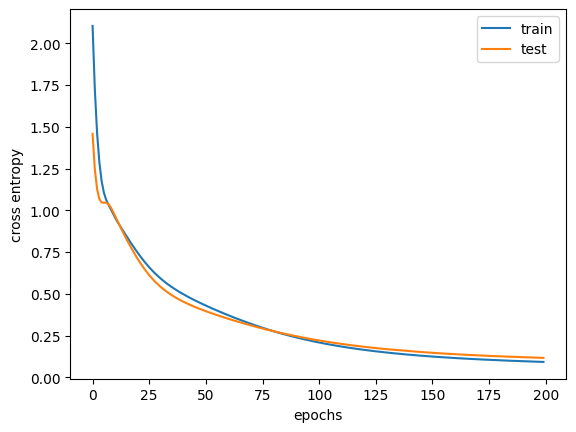

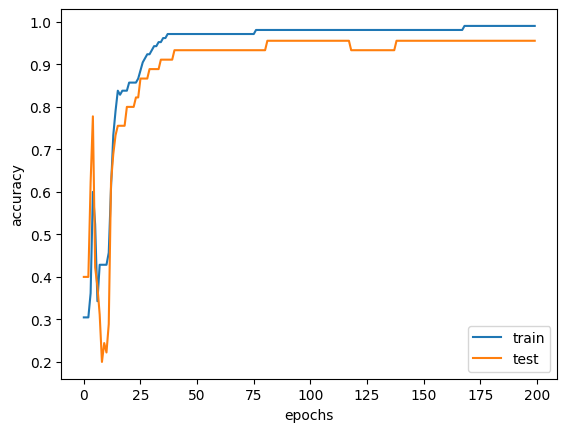

In [12]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Second Example

In [24]:
import torch 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(42)


In [25]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 12439396.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 120773373.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 13039748.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 31026919.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [36]:
x, y = next(iter(train_dataloader))
print(x.shape)
print(x.view(-1, 28*28).shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
net = Net()

In [6]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #e-1

In [7]:
epoch = 10

for epoch in range(epoch):
    net.train()

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()

In [9]:
correct = 0
total = 0
with torch.inference_mode():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.963


# Third Example

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|█████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 11529613.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 786293.80it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 8654810.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 15302818.56it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

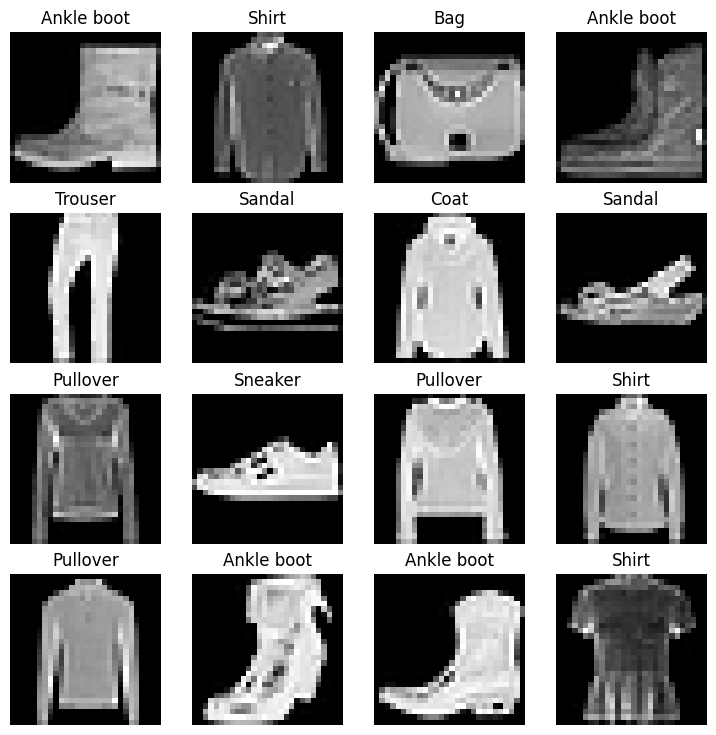

In [3]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [5]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
from torch import nn
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)


# Need to setup model with input parameters
fashionmodel = FashionMNISTModel(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, 
    output_shape=len(class_names) 
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=fashionmodel.parameters(), lr=0.1)

In [22]:
from tqdm.auto import tqdm
import torch
# Set the seed and start the timer
torch.manual_seed(42)

epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        fashionmodel.train() 
        # 1. Forward pass
        y_pred = fashionmodel(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    fashionmodel.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = fashionmodel(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            accuracy = Accuracy(task = 'multiclass',
                                num_classes=len(class_names))
            
            test_acc += accuracy(test_pred.argmax(dim=1),
                                 y)
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.41676 | Test loss: 0.45544, Test acc: 0.84%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.41574 | Test loss: 0.45790, Test acc: 0.84%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.41292 | Test loss: 0.46158, Test acc: 0.84%



In [23]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1),
                               y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": f'{acc}'}

# Calculate model 0 results on test dataset
fashionmodel_results = eval_model(model=fashionmodel, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=Accuracy(task = 'multiclass', num_classes=len(class_names))
)
fashionmodel_results



{'model_name': 'FashionMNISTModel',
 'model_loss': 0.46158137917518616,
 'model_acc': '0.842052698135376'}